In [2]:
import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
from heapq import nsmallest
from scipy.signal import butter, lfilter, freqz
from scipy.fftpack import fft, ifft
from scipy import integrate

### Lecture Data

In [2]:
theoric_lines = pd.read_csv('DataSet/Inputs/theoric_c_lines.txt', delimiter = '\t', header = 0)
theoric_lines['wave_peak'] = theoric_lines['wave_peak']/10
theoric_lines['wave_base'] = theoric_lines['wave_base']/10
theoric_lines['wave_top'] = theoric_lines['wave_top']/10

c_s = pd.read_csv('DataSet/Inputs/Subtracted_spectrum.txt', delimiter = '\t', header = 0)

data_klaus = pd.read_csv("DataSet/Inputs/Ti2_data_klaus.txt", delimiter = '\t', usecols = ['lambda', 'loggf', 'ewr1'], header = 0)

growth_c_ispec_gauss = pd.read_csv("DataSet/Outputs/Ti2_substract_ispec_gauss.dat", delimiter = '\t', usecols = ['wave_nm', 'wave_base', 'wave_top','loggf', 'ewr'], header = 0)
growth_c_ispec_voigth = pd.read_csv("DataSet/Outputs/Ti2_substract_ispec_voigth.dat", delimiter = '\t', usecols = ['wave_nm', 'wave_base', 'wave_top','loggf', 'ewr'], header = 0)

#growth_c_mine = pd.read_csv("DataSet/Outputs/Ti 2_growth_curve.dat", delimiter = '\t', header = 0)
Atomic_lines = pd.read_csv('DataSet/Inputs/atomic_lines.tsv', delimiter = '\t', usecols = ['element', 'wave_nm', 'loggf', 'lower_state_eV', 'upper_state_eV'],   header = 0, low_memory=False, keep_default_na= False)
Atomic_lines = Atomic_lines[(Atomic_lines['wave_nm']>=375) & (Atomic_lines['wave_nm']<=465)]

In [71]:
data_klausFe1 = pd.read_csv("DataSet/Inputs/Fe1_data_klaus.txt", delimiter = '\t', usecols = ['lambda', 'loggf', 'ewr1', 'ewr2'], header = 0)
data_klausTi2 = pd.read_csv("DataSet/Inputs/Ti2_data_klaus.txt", delimiter = '\t', usecols = ['lambda', 'loggf', 'ewr1', 'ewr2'], header = 0)

dataFe1_24oct = pd.read_csv("DataSet/Outputs/Fe 1_growth_curve_24oct.dat", delimiter = '\t', header = 0)
dataTi2_24oct = pd.read_csv("DataSet/Outputs/Ti 2_growth_curve_24oct.dat", delimiter = '\t', header = 0)

dataFe1_25oct = pd.read_csv("DataSet/Outputs/Fe 1_growth_curve_25oct.dat", delimiter = '\t', header = 0)
dataTi2_25oct = pd.read_csv("DataSet/Outputs/Ti 2_growth_curve_25oct.dat", delimiter = '\t', header = 0)

## Found absortion lines

In [77]:
top = []
for i in range(len(theoric_lines['wave_top'])):
    top.append(nsmallest(1,c_s['waveobs'], key = lambda x: abs(x-theoric_lines['wave_top'][i]))[0])

In [78]:
base = []
for i in range(len(theoric_lines['wave_base'])):
    base.append(nsmallest(1,c_s['waveobs'], key = lambda x: abs(x-theoric_lines['wave_base'][i]))[0])

In [81]:
#Create new list with contain the absortion lines in cromospheric spectrum with its respective element
c_lines_spectrum = pd.DataFrame(columns = ['wave_peak', 'wave_base', 'wave_top','note', 'flux', 'error_f'])
L = []
I = []
mins = []
       
for i in range(len(base)):
    b = c_s['waveobs']>base[i]
    a = c_s['waveobs']<top[i]
    c = a&b 
    min_ = min(c_s['flux'][c])
    L.append(c_s["waveobs"][c][c_s["flux"][c] == min_].tolist()[0])
    I.append(c_s['flux'][c][c_s["flux"][c] == min_].tolist()[0])
    mins.append(min_)
    
c_lines_spectrum['wave_peak'] = L
c_lines_spectrum['wave_base'] = base
c_lines_spectrum['wave_top'] = top
c_lines_spectrum['note'] = theoric_lines['note']
c_lines_spectrum['flux'] = I
c_lines_spectrum['error_f'] = c_s['err']

In [83]:
c_lines_spectrum.to_csv("c_lines_spectrum.txt", sep='\t', index = False, header=True)

## Test Equivalent Width

#### Fit

In [107]:
#Number of splines
def step_continuum(Lmin,Lmax,splines):
    return (Lmax-Lmin)/splines

#New dots to found continuous
def Points_continuum(_lambda, Intensity,start,end,step):
    
    steps_list = np.arange(start,end, step)
    grouped_data = {}
    grouped_data['L'] = []
    grouped_data['I'] = []
    for i in range(1,len(steps_list)):
        grouped_lambda = _lambda[(_lambda >= steps_list[i-1]) & (_lambda < steps_list[i])]

        grouped_data['L'].append(grouped_lambda)
        grouped_data['I'].append(Intensity[  grouped_lambda.index  ])
    return grouped_data

#Fit contunuous to line data
def fit_continuum(grouped_data, L_min, L_max):  
    newdataL = [] 
    newdataI = []
    for i in range(len(grouped_data['I'])):
        newdataL.append(grouped_data['L'][i].median())
        newdataI.append(grouped_data['I'][i].median())
        data_fitL = [x for x in newdataL if str(x) != 'nan']
        data_fitI = [x for x in newdataI if str(x) != 'nan']
    cs = InterpolatedUnivariateSpline(data_fitL,data_fitI)
    xs =  np.linspace(L_min,  L_max, 100)
    fit =  pd.DataFrame({'L': xs, 'I': cs(xs)})
    return fit

In [135]:
step = step_continuum(Ti2_gf['wave_base'][0],Ti2_gf['wave_top'][0],20)

grouped_data = Points_continuum(c_s['waveobs'], c_s['flux'],Ti2_gf['wave_base'][0],Ti2_gf['wave_top'][0],step)

fit1 = fit_continuum(grouped_data, Ti2_gf['wave_base'][0], Ti2_gf['wave_top'][0]+0.07)
fit = fit1[(fit1['L'] >= Ti2_gf['wave_base'][0]) & (fit1['L'] <= Ti2_gf['wave_top'][0])]


,L,I
0,376.075000,1.273505
1,376.077071,1.229357
2,376.079141,1.176255
3,376.081212,1.115694
4,376.083283,1.049175
...,...,...
61,376.201313,0.951128
62,376.203384,0.875268
63,376.205455,0.754169
64,376.207525,0.582042


#### Pseudocontinuou

In [120]:
def pseudocontinuou(Data,LMIN, LMAX):
    pseudo_continuous1 = c_s[(c_s['waveobs'] <= LMIN)  & (c_s['waveobs'] > (LMIN-0.05))]
    pseudo_continuous2 = c_s[(c_s['waveobs'] >= LMAX )  & (c_s['waveobs'] < (LMAX+0.05))]
    pseudo_continuous1.index = list(range(len(pseudo_continuous1)))
    pseudo_continuous2.index = list(range(len(pseudo_continuous2)))

    mean1 = np.mean(pseudo_continuous1)
    mean2 = np.mean(pseudo_continuous2)
    mean = (mean1['flux'] + mean2['flux'])/2
    return mean

In [121]:
mean = pseudocontinuou(c_s, Ti2_gf['wave_base'][0], Ti2_gf['wave_top'][0])

## Graph

### Equivalent width

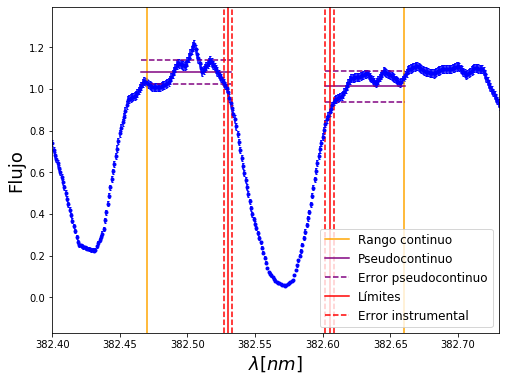

In [11]:
plt.figure(figsize = [8,6])

(_, caps, _) = plt.errorbar(c_s['waveobs'],c_s['flux'],c_s['err'], 0, color = 'blue', marker='.',ls = '',capsize=1)

for cap in caps:
    cap.set_markeredgewidth(1)
    
#plt.plot(c_s['waveobs'][7590],c_s['flux'][7590], color = 'red',marker='o', ls='', label = 'mins')

plt.xlim(382.4,382.73)

plt.axvline(382.47, color = 'orange', label ='Rango continuo')
plt.axhline(c_s['flux'][7490:7551].mean(), color = 'purple', xmin=0.2, xmax=0.4, label ='Pseudocontinuo' )
plt.axhline(c_s['flux'][7490:7551].mean() + c_s['flux'][7490:7551].std(), ls ='--', color = 'purple', xmin=0.2, xmax=0.4, label ='Error pseudocontinuo' )
plt.axhline(c_s['flux'][7490:7551].mean() - c_s['flux'][7490:7551].std(), ls ='--',color = 'purple', xmin=0.2, xmax=0.4 )


plt.axvline(382.53, color = 'red', label ='Límites')
plt.axvline(382.527, color = 'red', ls='--', label ='Error instrumental')
plt.axvline(382.533, color = 'red', ls='--')


plt.axvline(382.66, color = 'orange')

plt.axhline(c_s['flux'][7620:7680].mean(), color = 'purple', xmin=0.61, xmax=0.79)
plt.axhline(c_s['flux'][7620:7680].mean() + c_s['flux'][7620:7680].std(), ls ='--',color = 'purple', xmin=0.61, xmax=0.79)
plt.axhline(c_s['flux'][7620:7680].mean() - c_s['flux'][7620:7680].std(), ls ='--',color = 'purple', xmin=0.61, xmax=0.79)

plt.axvline(382.605, color = 'red')
plt.axvline(382.602, color = 'red', ls='--')
plt.axvline(382.608, color = 'red', ls='--')


#plt.axhline((c_s['flux'][7490:7551].mean() + c_s['flux'][7620:7680].mean())/2, color = 'magenta')


#plt.ylim(-2.5, 3)
plt.legend(loc="best")
plt.ylabel("Flujo",fontsize=18)
plt.xlabel("$\lambda [nm]$",fontsize=18)
plt.legend(fontsize = 12)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


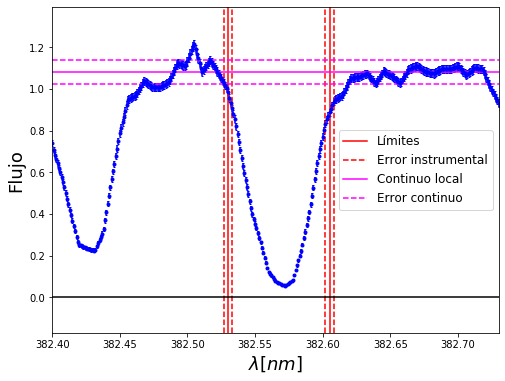

In [8]:
plt.figure(figsize = [8,6])

(_, caps, _) = plt.errorbar(c_s['waveobs'],c_s['flux'],c_s['err'], 0, color = 'blue', marker='.',ls = '',capsize=1)

for cap in caps:
    cap.set_markeredgewidth(1)
    

plt.axvline(382.53, color = 'red', label ='Límites')
plt.axvline(382.527, color = 'red', ls='--', label ='Error instrumental')
plt.axvline(382.533, color = 'red', ls='--')


plt.axvline(382.605, color = 'red')
plt.axvline(382.602, color = 'red', ls='--')
plt.axvline(382.608, color = 'red', ls='--')


#plt.axhline((c_s['flux'][7490:7551].mean() + c_s['flux'][7620:7680].mean())/2, color = 'magenta', label='Continuo local')
#plt.axhline((c_s['flux'][7490:7551].mean() + c_s['flux'][7620:7680].mean())/2 + (c_s['flux'][7620:7680].std() +c_s['flux'][7490:7551].std())/2, ls='--', color = 'magenta', label = 'Error de Continuo' )
#plt.axhline((c_s['flux'][7490:7551].mean() + c_s['flux'][7620:7680].mean())/2 - (c_s['flux'][7620:7680].std() +c_s['flux'][7490:7551].std())/2, ls='--', color = 'magenta')

plt.axhline(c_s['flux'][7490:7551].mean(), color = 'magenta', label='Continuo local')
plt.axhline(c_s['flux'][7490:7551].mean() + c_s['flux'][7490:7551].std(), ls ='--', color = 'magenta', label ='Error continuo' )
plt.axhline(c_s['flux'][7490:7551].mean() - c_s['flux'][7490:7551].std(), ls ='--',color = 'magenta' )

plt.axhline(0, color = 'black')

#plt.ylim(-2.5, 3)
plt.xlim(382.4,382.73)
#plt.grid()
#plt.legend(loc="best")
plt.ylabel("Flujo",fontsize=18)
plt.xlabel("$\lambda [nm]$",fontsize=18)
plt.legend(fontsize = 12)
plt.show()

# CURVAS DE CRECIMIENTO

## Ti ll

### Experimental

In [34]:
dataTi2_24oct  = dataTi2_24oct[~dataTi2_24oct.index.isin([11])]
dataTi2_24oct.index = list(range(len(dataTi2_24oct)))

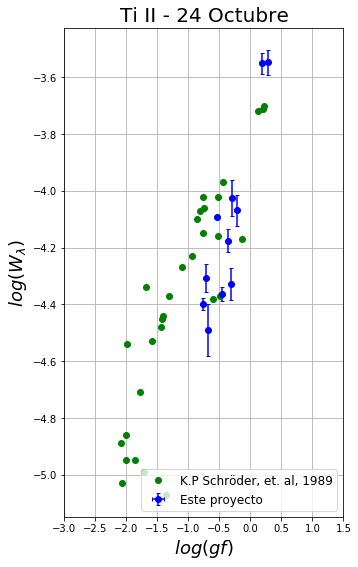

In [35]:
plt.figure(figsize = [5,9])

plt.plot(data_klausTi2['loggf'],data_klausTi2['ewr1'],marker='o', ls='', color = 'green', label = 'K.P Schröder, et. al, 1989')

(_, caps, _) = plt.errorbar(dataTi2_24oct['loggf'],dataTi2_24oct['EWR'],dataTi2_24oct['errEWR'], 0, color = 'blue', marker='o',ls = '',capsize=2,label = 'Este proyecto')

for cap in caps:
    cap.set_markeredgewidth(1)
    
plt.xlim(-3,1.5)
#plt.ylim(-5, -3.8)
plt.grid()
plt.legend(loc="best", fontsize=12)
plt.title('Ti II - 24 Octubre',fontsize=20)
plt.ylabel("$log(W_{\lambda})$",fontsize=18)
plt.xlabel("$log(gf)$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

In [61]:
dataTi2_25oct  = dataTi2_25oct[~dataTi2_25oct.index.isin([14])]
dataTi2_25oct.index = list(range(len(dataTi2_25oct)))

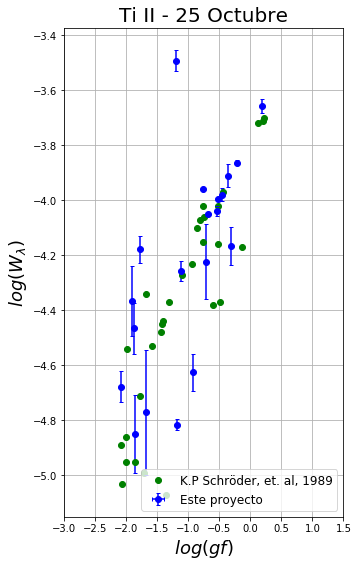

In [77]:
plt.figure(figsize = [5,9])

plt.plot(data_klausTi2['loggf'],data_klausTi2['ewr1'],marker='o', ls='', color = 'green', label = 'K.P Schröder, et. al, 1989')

(_, caps, _) = plt.errorbar(dataTi2_25oct['loggf'],dataTi2_25oct['EWR'],dataTi2_25oct['errEWR']*0.6, 0, color = 'blue', marker='o',ls = '',capsize=2,label = 'Este proyecto')

for cap in caps:
    cap.set_markeredgewidth(1)
    
plt.xlim(-3,1.5)
#plt.ylim(-5, -3.8)
plt.grid()
plt.legend(loc="best", fontsize=12)
plt.title('Ti II - 25 Octubre',fontsize=20)
plt.ylabel("$log(W_{\lambda})$",fontsize=18)
plt.xlabel("$log(gf)$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

### Teórica

In [65]:
def Growth_theoric(gf,_lambda,E_i,T_exc):
    return gf*_lambda*np.exp(-E_i/T_exc)/(27.0)


theo_Ti2_24oct = []
for i in range(0,len(dataTi2_24oct['loggf'])):
    theo_Ti2_24oct.append(Growth_theoric(10**(dataTi2_24oct['loggf'][i]), dataTi2_24oct['wave_peak'][i], (dataTi2_24oct['upper_state_eV'][i] - dataTi2_24oct['lower_state_eV'][i] ), 5000))

    
def ajuste(x,a,b):
    return a*x + b

popt1, pcov1 = scipy.optimize.curve_fit(ajuste, np.log(theo_Ti2_24oct), dataTi2_24oct['EWR'])

xfit_Ti2_24 = np.linspace(min(np.log(theo_Ti2_24oct)), max(np.log(theo_Ti2_24oct)), 100)
yfit_Ti2_24 = ajuste(xfit_Ti2_24,*popt1)

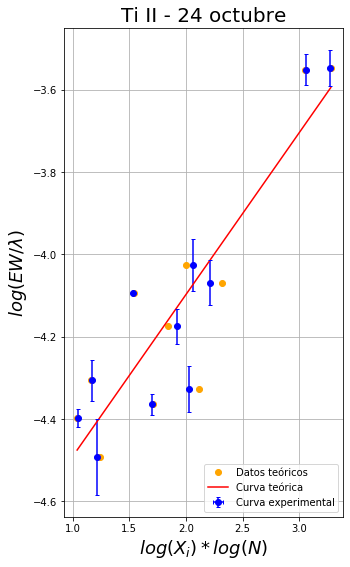

In [47]:
plt.figure(figsize = [5,9])

plt.plot(np.log(theo_Ti2_24oct), dataTi2_24oct['EWR'],marker='o', color = 'orange', ls='', label = 'Datos teóricos')
plt.plot(xfit_Ti2_24,yfit_Ti2_24,marker='', ls='-', color = 'red', label = 'Curva teórica')
(_, caps, _) = plt.errorbar((dataTi2_24oct['loggf']*2.12+2.68),dataTi2_24oct['EWR'],dataTi2_24oct['errEWR'], 0, color = 'blue', marker='o',ls = '',capsize=2,label = 'Curva experimental')

for cap in caps:
    cap.set_markeredgewidth(1)

#plt.xlim(-4,25)
#plt.ylim(-6, -3.5)
plt.grid()
plt.legend(loc="lower right")
plt.title('Ti II - 24 octubre',fontsize=20)
plt.ylabel("$log(EW/\lambda)$",fontsize=18)
plt.xlabel("$log(X_i)*log(N)$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

In [66]:
theo_Ti2_25oct = []
for i in range(0,len(dataTi2_25oct['loggf'])):
    theo_Ti2_25oct.append(Growth_theoric(10**(dataTi2_25oct['loggf'][i]), dataTi2_25oct['wave_peak'][i], (dataTi2_25oct['upper_state_eV'][i] - dataTi2_25oct['lower_state_eV'][i] ), 5000))

popt, pcov = scipy.optimize.curve_fit(ajuste, np.log(theo_Ti2_25oct), dataTi2_25oct['EWR'])

xfit_Ti2_25 = np.linspace(min(np.log(theo_Ti2_25oct)), max(np.log(theo_Ti2_25oct)), 100)
yfit_Ti2_25 = ajuste(xfit_Ti2_25,*popt)

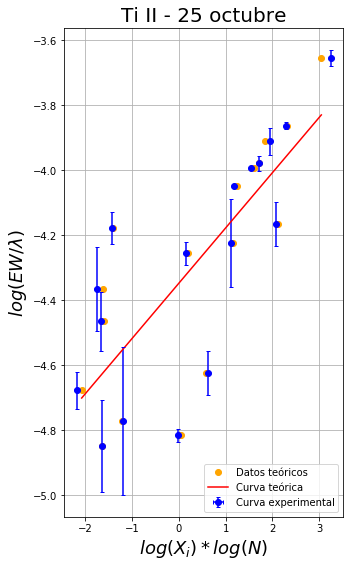

In [68]:
plt.figure(figsize = [5,9])

plt.plot(np.log(theo_Ti2_25oct), dataTi2_25oct['EWR'],marker='o', color = 'orange', ls='', label = 'Datos teóricos')
plt.plot(xfit_Ti2_25,yfit_Ti2_25,marker='', ls='-', color = 'red', label = 'Curva teórica')
(_, caps, _) = plt.errorbar((dataTi2_25oct['loggf']*2.39+2.82),dataTi2_25oct['EWR'],dataTi2_25oct['errEWR']*0.6, 0, color = 'blue', marker='o',ls = '',capsize=2,label = 'Curva experimental')

for cap in caps:
    cap.set_markeredgewidth(1)

#plt.xlim(-4,25)
#plt.ylim(-6, -3.5)
plt.grid()
plt.legend(loc="lower right")
plt.title('Ti II - 25 octubre',fontsize=20)
plt.ylabel("$log(EW/\lambda)$",fontsize=18)
plt.xlabel("$log(X_i)*log(N)$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

## Fe l

### Experimentales

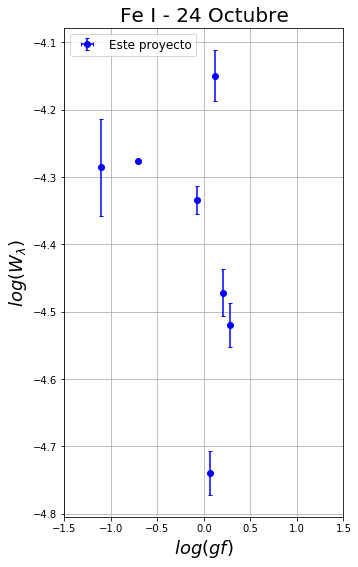

In [78]:
plt.figure(figsize = [5,9])

#plt.plot(data_klausFe1['loggf'],data_klausFe1['ewr2'],marker='o', ls='', color = 'green', label = 'K.P Schröder, et. al, 1989')

(_, caps, _) = plt.errorbar(dataFe1_24oct['loggf'],dataFe1_24oct['EWR'],dataFe1_24oct['errEWR']*0.6, 0, color = 'blue', marker='o',ls = '',capsize=2,label = 'Este proyecto')

for cap in caps:
    cap.set_markeredgewidth(1)

    
plt.xlim(-1.5,1.5)
#plt.ylim(-5, -3.8)
plt.grid()
plt.legend(loc="best", fontsize=12)
plt.title('Fe I - 24 Octubre',fontsize=20)
plt.ylabel("$log(W_{\lambda})$",fontsize=18)
plt.xlabel("$log(gf)$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

In [82]:
dataFe1_25oct  = dataFe1_25oct[~dataFe1_25oct.index.isin([4,11])]
dataFe1_25oct.index = list(range(len(dataFe1_25oct)))

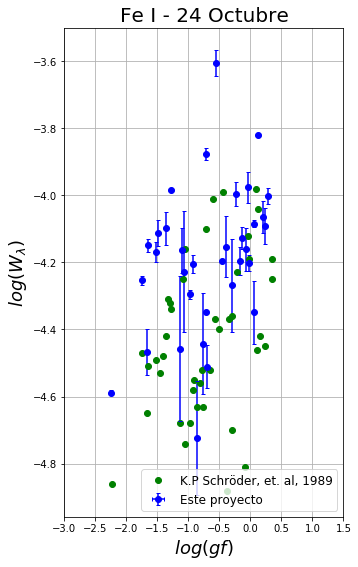

In [86]:
plt.figure(figsize = [5,9])

plt.plot(data_klausFe1['loggf'],data_klausFe1['ewr1'],marker='o', ls='', color = 'green', label = 'K.P Schröder, et. al, 1989')

(_, caps, _) = plt.errorbar(dataFe1_25oct['loggf'],dataFe1_25oct['EWR'],dataFe1_25oct['errEWR']*0.4, 0, color = 'blue', marker='o',ls = '',capsize=2,label = 'Este proyecto')

for cap in caps:
    cap.set_markeredgewidth(1)

    
plt.xlim(-3,1.5)
#plt.ylim(-5, -3.8)
plt.grid()
plt.legend(loc="best", fontsize=12)
plt.title('Fe I - 25 Octubre',fontsize=20)
plt.ylabel("$log(W_{\lambda})$",fontsize=18)
plt.xlabel("$log(gf)$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

### Teóricas

In [103]:
theo_Fe1_24oct = []
for i in range(0,len(dataFe1_24oct['loggf'])):
    theo_Fe1_24oct.append(Growth_theoric(10**(dataFe1_24oct['loggf'][i]), dataFe1_24oct['wave_peak'][i], (dataFe1_24oct['upper_state_eV'][i] - dataFe1_24oct['lower_state_eV'][i] ), 5000))

popt4, pcov4 = scipy.optimize.curve_fit(ajuste, np.log(theo_Fe1_24oct), dataFe1_24oct['EWR'])

xfit_Fe1_24= np.linspace(min(np.log(theo_Fe1_24oct)), max(np.log(theo_Fe1_24oct)), 100)
yfit_Fe1_24 = ajuste(xfit_Fe1_24,*popt3)

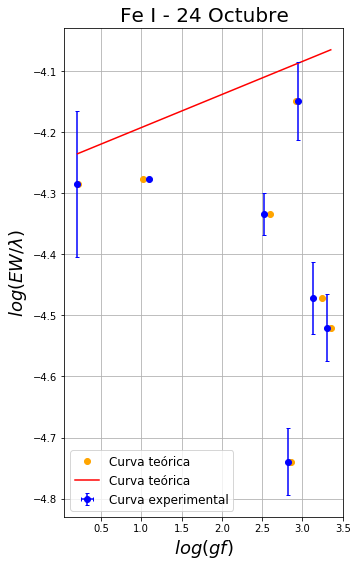

In [110]:
plt.figure(figsize = [5,9])

plt.plot(np.log(theo_Fe1_24oct),dataFe1_24oct['EWR'],marker='o', ls='', color = 'orange', label = 'Curva teórica')
plt.plot(xfit_Fe1_24,yfit_Fe1_24,marker='', ls='-', color = 'red', label = 'Curva teórica')

(_, caps, _) = plt.errorbar((dataFe1_24oct['loggf']*2.23 +2.68),dataFe1_24oct['EWR'],dataFe1_24oct['errEWR'], 0, color = 'blue', marker='o',ls = '',capsize=2,label = 'Curva experimental')

for cap in caps:
    cap.set_markeredgewidth(1)
    
#plt.xlim(-20,25)
#plt.ylim(-6, -3.5)
plt.grid()
plt.legend(loc="lower right")
plt.title('Fe I - 24 Octubre',fontsize=20)
plt.ylabel("$log(EW/\lambda)$",fontsize=18)
plt.xlabel("$log(gf)$",fontsize=18)
#plt.xscale('log')

plt.legend(fontsize = 12)
plt.show()

In [88]:
theo_Fe1_25oct = []
for i in range(0,len(dataFe1_25oct['loggf'])):
    theo_Fe1_25oct.append(Growth_theoric(10**(dataFe1_25oct['loggf'][i]), dataFe1_25oct['wave_peak'][i], (dataFe1_25oct['upper_state_eV'][i] - dataFe1_25oct['lower_state_eV'][i] ), 5000))

popt3, pcov3 = scipy.optimize.curve_fit(ajuste, np.log(theo_Fe1_25oct), dataFe1_25oct['EWR'])

xfit_Fe1_25 = np.linspace(min(np.log(theo_Fe1_25oct)), max(np.log(theo_Fe1_25oct)), 100)
xfit_Fe1_25 = ajuste(xfit_Fe1_25,*popt3)

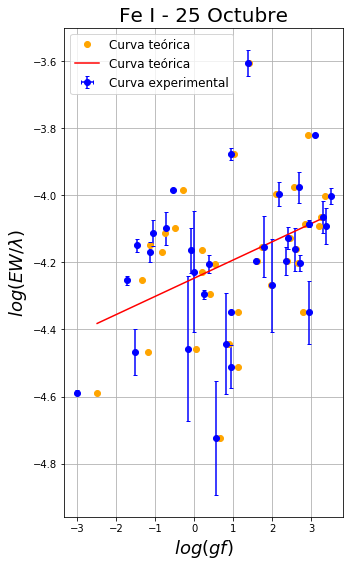

In [100]:
plt.figure(figsize = [5,9])

plt.plot(np.log(theo_Fe1_25oct),dataFe1_25oct['EWR'],marker='o', ls='', color = 'orange', label = 'Curva teórica')
plt.plot(xfit_Fe1_25,yfit_Fe1_25,marker='', ls='-', color = 'red', label = 'Curva teórica')

(_, caps, _) = plt.errorbar((dataFe1_25oct['loggf']*2.58 +2.78),dataFe1_25oct['EWR'],dataFe1_25oct['errEWR']*0.4, 0, color = 'blue', marker='o',ls = '',capsize=2,label = 'Curva experimental')

for cap in caps:
    cap.set_markeredgewidth(1)
    
#plt.xlim(-20,25)
#plt.ylim(-6, -3.5)
plt.grid()
plt.legend(loc="lower right")
plt.title('Fe I - 25 Octubre',fontsize=20)
plt.ylabel("$log(EW/\lambda)$",fontsize=18)
plt.xlabel("$log(gf)$",fontsize=18)
#plt.xscale('log')

plt.legend(fontsize = 12)
plt.show()

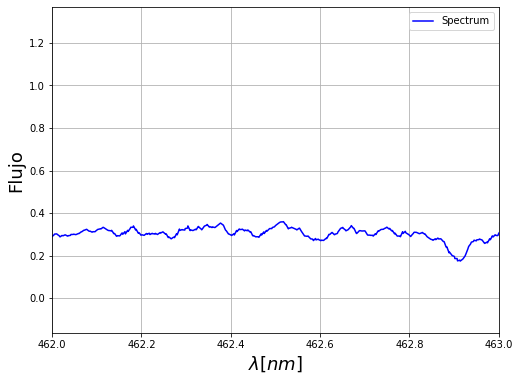

In [662]:
plt.figure(figsize = [8,6])

plt.plot(c_s['waveobs'],c_s['flux'],color = 'blue', marker='',ls = '-',label = 'Spectrum')


plt.axvline(458.31, color = 'red')
plt.axvline(458.416, color = 'red')

plt.xlim(462, 463)
plt.grid()
plt.legend(loc="best")
plt.ylabel("Flujo",fontsize=18)
plt.xlabel("$\lambda [nm]$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

In [3]:
b = c_s['waveobs']>376.075
a = c_s['waveobs']<376.210
c = a&b
errorA2 = np.sqrt(np.sum(c_s['err'][c]**2))

In [4]:
errorA2

0.20710838958897468

In [26]:
1.2*(0.05/1.2)*((0.03 + 0.03)/(0.1))

0.03

In [12]:
np.sqrt(np.sum(c_s['err'][c]**2))

0.20710838958897468